#### Importing neccessary libraries

1. **Numpy** for *linear algebra*
2. **Pandas** for reading csv files and DataFrame handling
3. **Tensorflow** for *machine learning*
4. **Keras** for defining the *LSTM model architecture* and regularization
5. Functions such as **train_test_split** for dividing the dataset into training and test set and **GridSearchCV** to tune hyperparameters across a grid of values.
6. **MinMaxScaler** to scale the variable values to a range of $[0,1]$.  
7. **matplotlib** for plotting results
8. **logging** for errors.

In [9]:
pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 42.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasClassifier
from itertools import product
import matplotlib.pyplot as plt
import logging
from keras.regularizers import l2

# 6 iterations:
1. -> 1 lstm layers gridsearch  
2. -> 2 lstm layer gridsearch  
3. -> 1 lstm layer med l1 eller l2 gridsearch  
4. -> 1 lstm layer for kun makro gridsearch  
5. -> 1 lstm layer for kun technical gridsearch  
6. -> 1 lstm layer med inflation og unemployment + tekniske (Momentum, RSI, MACD, MA) gridsearch


## Configuration of logging:

In [2]:
logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s')

## Setting Device to GPU

Since the model is run in Google Colab with an external GPU for increased computational ability the device which is used needs to be defined:

In [32]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    logging.warning('GPU device not found. Use CPU instead')
else:
    logging.info(f'Found GPU at: {device_name}')

# Data Loading

In [46]:
logging.info('Loading dataset...')

file_path = '/content/final_dataset.csv'
df = pd.read_csv(file_path)
dataset = df.values[:, 1:].astype('float64') # Later this can be changed to float64 for further precision.

diff = dataset[:,:1]

In [47]:
np.random.seed(42)
tf.random.set_seed(42)

# Output Variable Transformation and Data Scaling

In [48]:
# Define a function to categorize the percent change
# Values for (25,75) and (40,60) percentiles are listed below. Both will be tested.
#25th: -0.0037000000000000366
#75th: 0.003649999999999931
#40th: -0.0012000000000000899
#60th: 0.0013000000000000789
#33th: -0.0023999999999999
#66th: 0.0021999999999999

def categorize_diff(diff):
    if diff < -0.0021999999999999:
        return 0  # Price falls
    elif diff > 0.002:
        return 2  # Price rises
    else:
        return 1  # Price stays the same

# Apply the function to y_diff to get the categories
logging.info('Categorizing percent change...')
y_categories = np.array([categorize_diff(pc) for pc in diff])

# Normalizing dataset
logging.info('Normalizing dataset...')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset[:, 1:])


# Conversion to Tensor

In [49]:
def create_dataset(dataset, time_steps=1):
    dataX = []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), :]
        dataX.append(a)
    return np.array(dataX)

# 1st Model

* time steps = 10,
* epochs = 100,
* 1 hidden layer,
* 0.3 dropout rate,
* 32 batch size,

In [8]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)

In [9]:
def create_model(units1=128, dropout_rate1 = 0.3, batch_size = 32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
model = KerasClassifier(model=create_model, epochs = 75, verbose=0, shuffle = False, random_state = 42)

In [11]:
param_grid = {
    'model__units1': [32, 64, 128, 256],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'batch_size': [32, 64, 128]
}

In [12]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs = -1)

In [13]:
# Fit the grid search
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [14]:
best_params = grid_result.best_params_
logging.info(f"Best Parameters: {best_params}")
print(best_params)

{'batch_size': 32, 'model__dropout_rate1': 0.4, 'model__units1': 128}


In [15]:
best_model = create_model(batch_size = best_params['batch_size'],
                          dropout_rate1 = best_params['model__dropout_rate1'],
                          units1 = best_params['model__units1']
                          )

In [16]:
history = best_model.fit(X_train, y_train,
                         epochs = 75,
                         batch_size = best_params['batch_size'],
                         validation_data = (X_test, y_test),
                         shuffle = False,
                         verbose=0
                         )

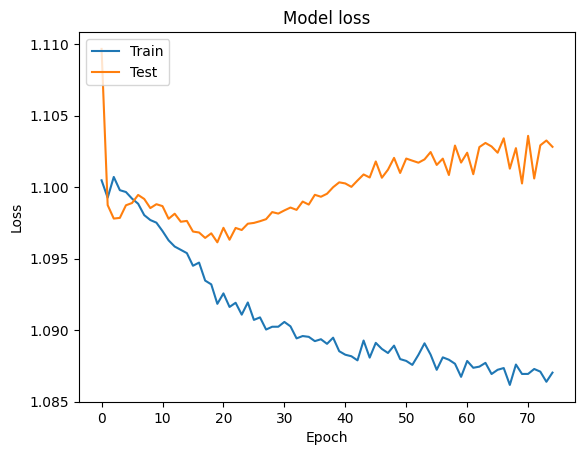

In [19]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<Figure size 1000x700 with 0 Axes>

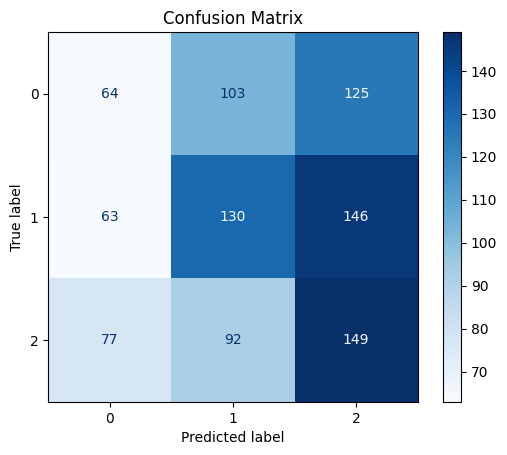

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model.predict(X_test)

actual_categories = y_test
predicted_categories = np.argmax(y_pred, axis=1)

cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [21]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128)                 │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,779 (940.55 KB)

 Trainable params: 80,259 (313.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160,520 (627.04 KB)

In [24]:
model_save_path = 'first_iteration_lstm.keras'
best_model.save(model_save_path)
logging.info(f"Model saved to {model_save_path}")


In [492]:
loaded_model = tf.keras.models.load_model(model_save_path)
loaded_model.summary()

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_63 (LSTM)                       │ (None, 128)                 │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,779 (940.55 KB)

 Trainable params: 80,259 (313.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160,520 (627.04 KB)

# 2nd Iteration

2 lstm layer gridsearch

In [37]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)

In [38]:
def create_model_2(units1=128, units2 = 64, dropout_rate1 = 0.3, dropout_rate2 = 0.2, batch_size = 32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = True),
        Dropout(dropout_rate1),
        LSTM(units2, return_sequences = False),
        Dropout(dropout_rate2),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [26]:
model_2 = KerasClassifier(model=create_model_2, epochs = 75, verbose=0, shuffle = False, random_state = 42)

In [27]:
param_grid_model2 = {
    'model__units1': [32, 64, 128],
    'model__units2': [32, 64, 128],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'model__dropout_rate2': [0.3, 0.2, 0.1],
    'batch_size': [32, 64, 128]
}

In [28]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_2 = GridSearchCV(estimator=model_2, param_grid=param_grid_model2, cv=5, n_jobs = -1)

In [29]:
# Fit the grid search
grid_result_model_2 = grid_model_2.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [30]:
best_params_model_2 = grid_result_model_2.best_params_
logging.info(f"Best Parameters: {best_params_model_2}")
print(best_params_model_2)

{'batch_size': 32, 'model__dropout_rate1': 0.2, 'model__dropout_rate2': 0.1, 'model__units1': 128, 'model__units2': 128}


In [39]:
best_model_2 = create_model_2(units1=best_params_model_2['model__units1'],
                            units2 = best_params_model_2['model__units2'],
                          dropout_rate1 = best_params_model_2['model__dropout_rate1'],
                            dropout_rate2 = best_params_model_2['model__dropout_rate2'],
                          batch_size = best_params_model_2['batch_size']
                          )

In [40]:
history_model_2 = best_model_2.fit(X_train, y_train,
                         epochs=75,
                         validation_data=(X_test, y_test),
                         verbose=0)

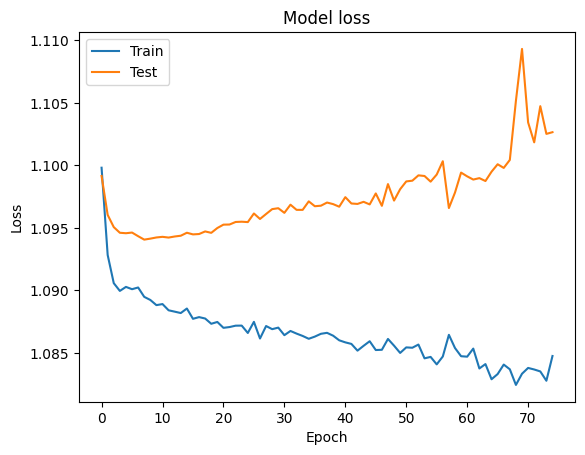

In [41]:
# Plot training & validation loss values
plt.plot(history_model_2.history['loss'])
plt.plot(history_model_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


<Figure size 1000x700 with 0 Axes>

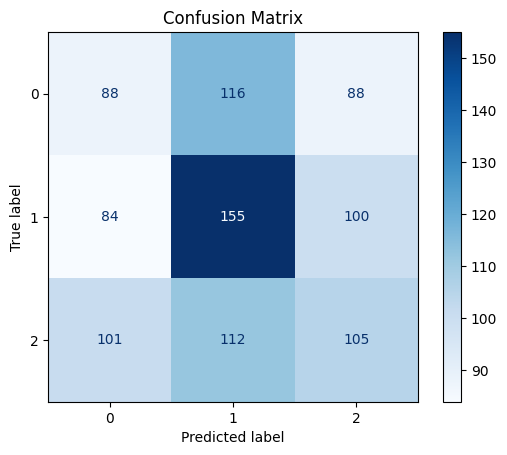

In [42]:
y_pred = best_model_2.predict(X_test)

actual_categories = y_test
predicted_categories = np.argmax(y_pred, axis=1)

cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [43]:
best_model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 15, 128)             │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 15, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 635,531 (2.42 MB)

 Trainable params: 211,843 (827.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 423,688 (1.62 MB)

In [44]:
model_2_save_path = 'second_iteration_lstm.keras'
best_model_2.save(model_2_save_path)
logging.info(f"Model saved to {model_2_save_path}")


# 3rd Iteration

1 lstm layer med l1 eller l2 gridsearch  


In [45]:
from tensorflow.keras.regularizers import l1_l2

In [50]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [61]:
def create_model_3(units1=128, dropout_rate1 = 0.3, batch_size = 32, l1 = 0.01, l2 = 0.01):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation='softmax', kernel_regularizer = l1_l2(l1=l1, l2=l2))
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [62]:
model_3 = KerasClassifier(model=create_model_3, epochs = 100, verbose=0, random_state = 42)

In [63]:
param_grid_model3 = {
    'model__units1': [32, 64, 128],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'batch_size': [32, 64, 128],
    'model__l1': [0.01, 0.001],
    'model__l2': [0.01, 0.001]
}

In [64]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_3 = GridSearchCV(estimator=model_3, param_grid=param_grid_model3, cv=5, n_jobs = -1)

In [65]:
# Fit the grid search
grid_result_model_3 = grid_model_3.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [66]:
best_params_model_3 = grid_result_model_3.best_params_
logging.info(f"Best Parameters: {best_params_model_3}")
print(best_params_model_3)

{'batch_size': 32, 'model__dropout_rate1': 0.4, 'model__l1': 0.01, 'model__l2': 0.01, 'model__units1': 128}


In [73]:
best_model_3 = create_model_3(units1 = best_params_model_3['model__units1'],
                          dropout_rate1 = best_params_model_3['model__dropout_rate1'],
                          batch_size = best_params_model_3['batch_size'],
                          l1 = best_params_model_3['model__l1'],
                          l2 = best_params_model_3['model__l2']
                          )

In [74]:
history_model_3 = best_model_3.fit(X_train, y_train,
                         epochs=100,
                         validation_data=(X_test, y_test),
                         verbose=0)

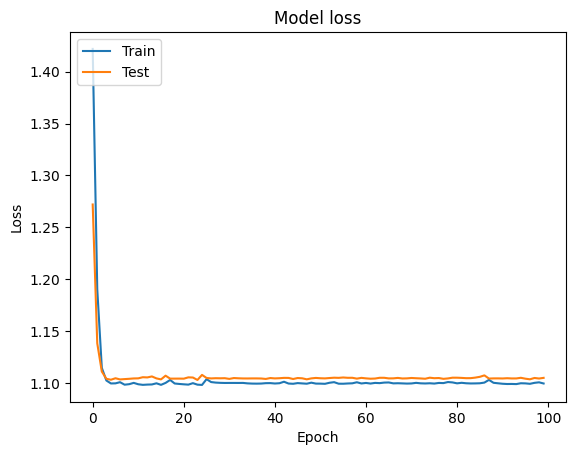

In [75]:
# Plot training & validation loss values
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<Figure size 1000x700 with 0 Axes>

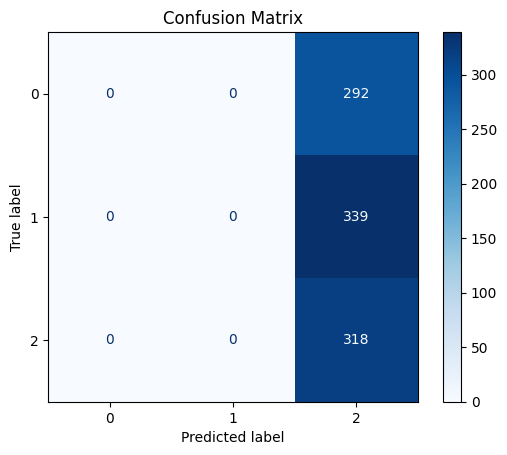

In [76]:
y_pred = best_model_3.predict(X_test)

actual_categories = y_test
predicted_categories = np.argmax(y_pred, axis=1)

cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [77]:
best_model_3.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 128)                 │          79,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 240,779 (940.55 KB)

 Trainable params: 80,259 (313.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 160,520 (627.04 KB)

In [78]:
model_3_save_path = 'third_iteration_lstm.keras'
best_model_3.save(model_3_save_path)
logging.info(f"Model saved to {model_3_save_path}")


# 4th Model (Not run yet)


In [ ]:
time_steps = 10

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
def create_advanced_model(units1 = 128, units2 = 64, dropout_rate1 = 0.2,dropout_rate2 = 0.1, batch_size = 32):
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),  # Explicitly define the input shape
        LSTM(units1, return_sequences = True),
        Dropout(dropout_rate1),
        LSTM(units2, return_sequences = False),
        Dropout(dropout_rate2),
        Dense(3, activation = 'softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
param_grid_advanced = {
    'model__units1': [64, 128],
    'model__units2': [32, 64],
    'model__dropout_rate1': [0.1, 0.2, 0.3],
    'model__dropout_rate2': [0.1, 0.3, 0.3],
    'batch_size': [32, 64, 128]
}

In [ ]:
model_4 = KerasClassifier(model=create_advanced_model, epochs = 100, verbose=0)

In [ ]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_4 = GridSearchCV(estimator=model_4, param_grid=param_grid_advanced, cv=5, scoring = 'accuracy', n_jobs = -1)

In [ ]:
# Fit the grid search
grid_result_model_4 = grid_model_4.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

# 5th Model (Not run yet)

In [ ]:
time_steps = 20

In [ ]:
model_5 = KerasClassifier(model=create_advanced_model, epochs = 100, verbose=0)

In [ ]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_5 = GridSearchCV(estimator=model_5, param_grid=param_grid, cv=5, n_jobs = -1)

In [ ]:
# Fit the grid search
grid_result_model_5 = grid_model_5.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
45 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following erro